In [154]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import scipy.fftpack
import random

Variable initialization

In [155]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion


C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

Text(0.5, 1.0, 'DCT basis')

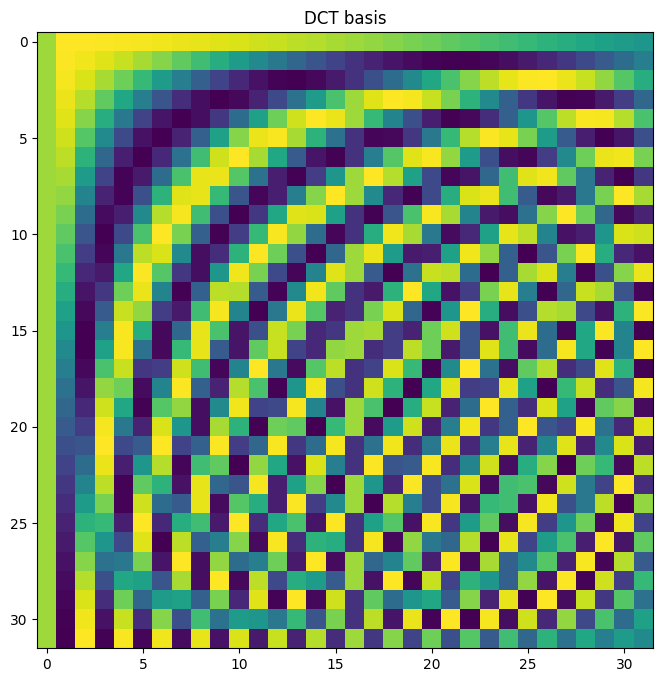

In [156]:
for i in range(M):
    a = np.zeros(M)
    a[i] = 1
    DCT[:, i] = sp.fftpack.idct(a, norm='ortho')

plt.figure(figsize=(8,8))
plt.imshow(DCT)
plt.title('DCT basis')


Generating the 1-D standard basis

Text(0.5, 1.0, 'Canonical basis dimension n = 32')

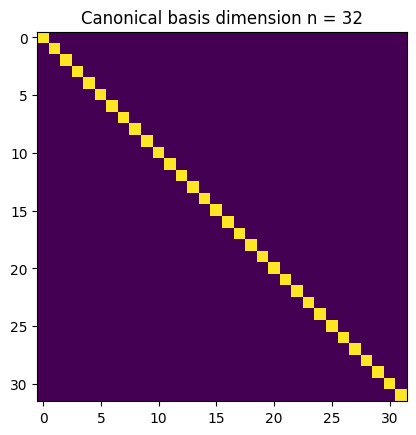

In [157]:
for i in range(M):
    a = np.zeros(M)
    a[i] = 1
    C[:, i] = a

plt.figure(5)
plt.imshow(C)
plt.title(f'Canonical basis dimension n = {M}')

Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

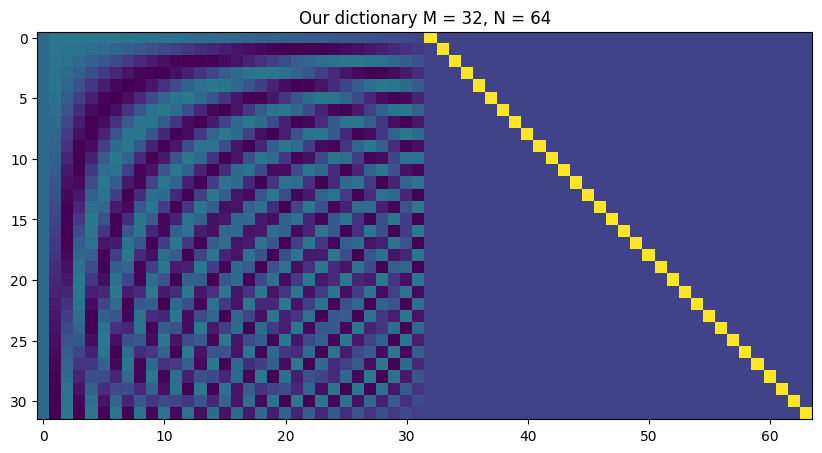

In [158]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $[D, C]$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [159]:
L = 5
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [160]:
ind = np.random.randint(0,M,L)
x0 = np.zeros(N)
x0[ind] = np.random.rand(L) + 2

Choose spike location

In [161]:
spikeLocation = random.randint(M,N) 
# the spike needs to be placed in the last coefficients of D, wrt to the canonical basis
x0[spikeLocation] = -10

Synthetize the corresponding signal in the signal domain and add noise


In [162]:
s0 = D@x0
s = s0 + np.random.normal(size=M) * sigma_noise

Plot the sparse signal

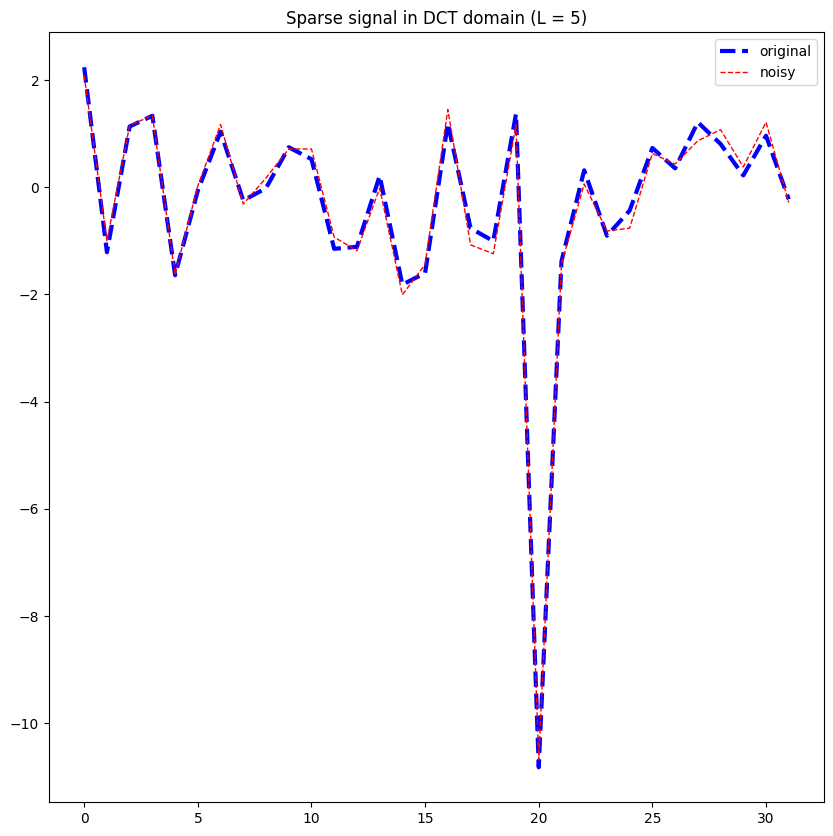

In [163]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(10,10))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Orthogonal Matching Pursuit
---------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [164]:
x_OMP = np.zeros(N)
# residual
r = s
# support set
omega = []

MINIMUM_NORM_RES = 0.1

OMP loop starts.

Stopping criteria: continue until the sparsity of the representation reaches L 

In [165]:
while np.count_nonzero(x_OMP) <= L:
  # SWEEP STEP: look for the column of D that matches at best noisySignal
  # compute the residual w.r.t. each column of D
  e = np.zeros(N)
  z= np.zeros(N)
  for j in range(N):
    z[j] = r.T @ D[:,j] 
    e[j] = np.linalg.norm(r,2)**2 - (z[j]**2) 
  # find the column of D that matches at best r
  jStar = np.argmin(e)

  # UPDATE the support set with the jStar coefficient
  omega.append(jStar)

  # update the coefficients by solving the least square problem min ||D_omega x - s ||
  #x_OMP[omega] = np.linalg.inv(D[:,omega].T@D[:,omega]) @ D[:,omega].T @ s
  # without computing the inverse:
  x_OMP[omega] = np.linalg.solve(D[:,omega].T@D[:,omega], D[:,omega].T @ s)

  # update the residual 
  r = s - D@x_OMP

SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [166]:
s_hat_OMP = D@x_OMP

Show the result

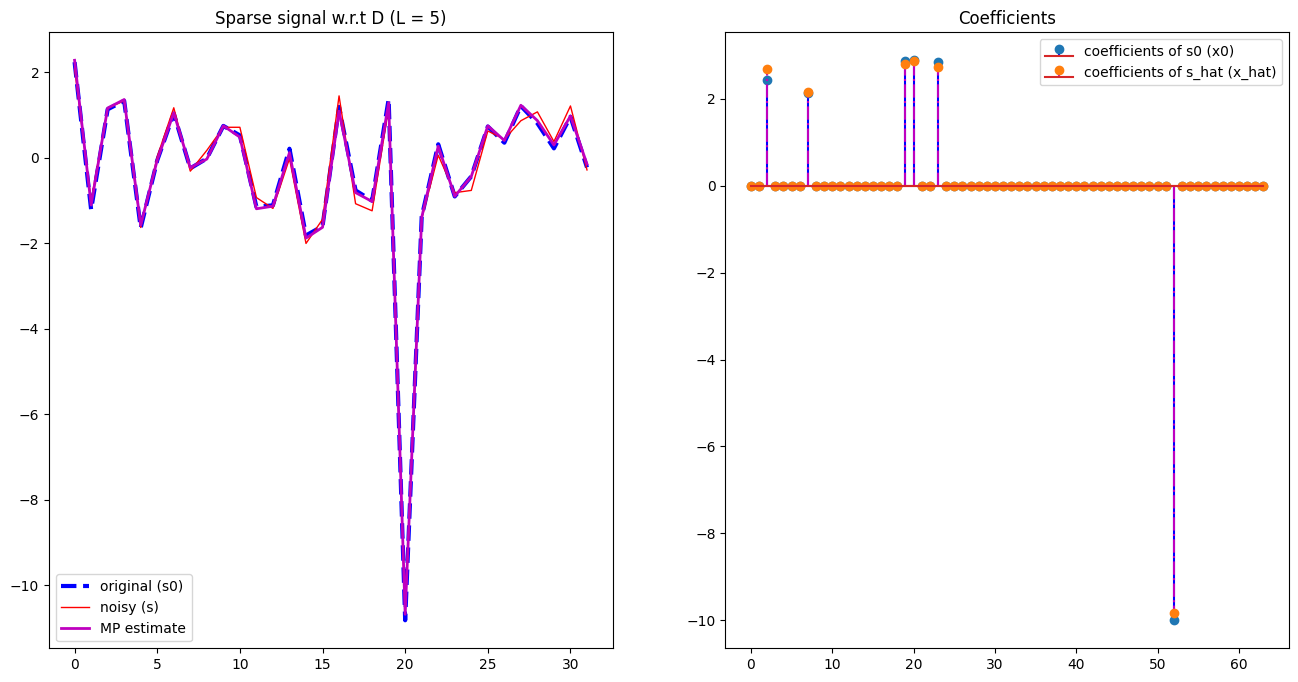

In [167]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b--', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_OMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_OMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

Least Squares Orthogonal Matching Pursuit
-----------------------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [168]:
x_LSOMP = np.zeros(N)
# residual
r = s
# support set
omega = []

MINIMUM_NORM_RES = 0.1

LSOMP loop starts.

Stopping criteria: continue until the sparsity of the representation reaches L 

In [169]:
while np.count_nonzero(x_LSOMP) <= L:

    if len(omega) == 0:
        e = np.zeros(N)
        z= np.zeros(N)
        # at the first iteration perform the usual sweep step
        for j in range(N):
          z[j] = r.T @ D[:,j] 
          e[j] = (np.linalg.norm(r,2))**2 - (z[j]**2) 
        jStar = np.argmin(e) 
        omega.append(jStar)
        x_LSOMP[jStar] = z[jStar]

    else:
        e= np.full(N,float('inf'))
        for j in range(N):
          if not(j in omega):
            D_omega_j = np.hstack((D[:,omega],D[:,j].reshape((M,1))))
            inv = np.linalg.inv(D_omega_j.T @ D_omega_j)
            uz = inv @ D_omega_j.T @ s
            e[j] = np.linalg.norm(D_omega_j @ uz - s, 2)**2

        # perform the sweep step by solving the LS problem
        jStar = np.argmin(e)

        # UPDATE the support set with the jStar coefficient
        omega.append(jStar)
        # update the coefficients 
        inv= np.linalg.inv(D[:,omega].T @ D[:,omega])
        uz= inv @ D[:,omega].T @ s
        x_LSOMP[omega] = uz

    # update the residual
    r = s - D@x_LSOMP    

SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [170]:
s_hat_LSOMP = D@x_LSOMP

Show the result

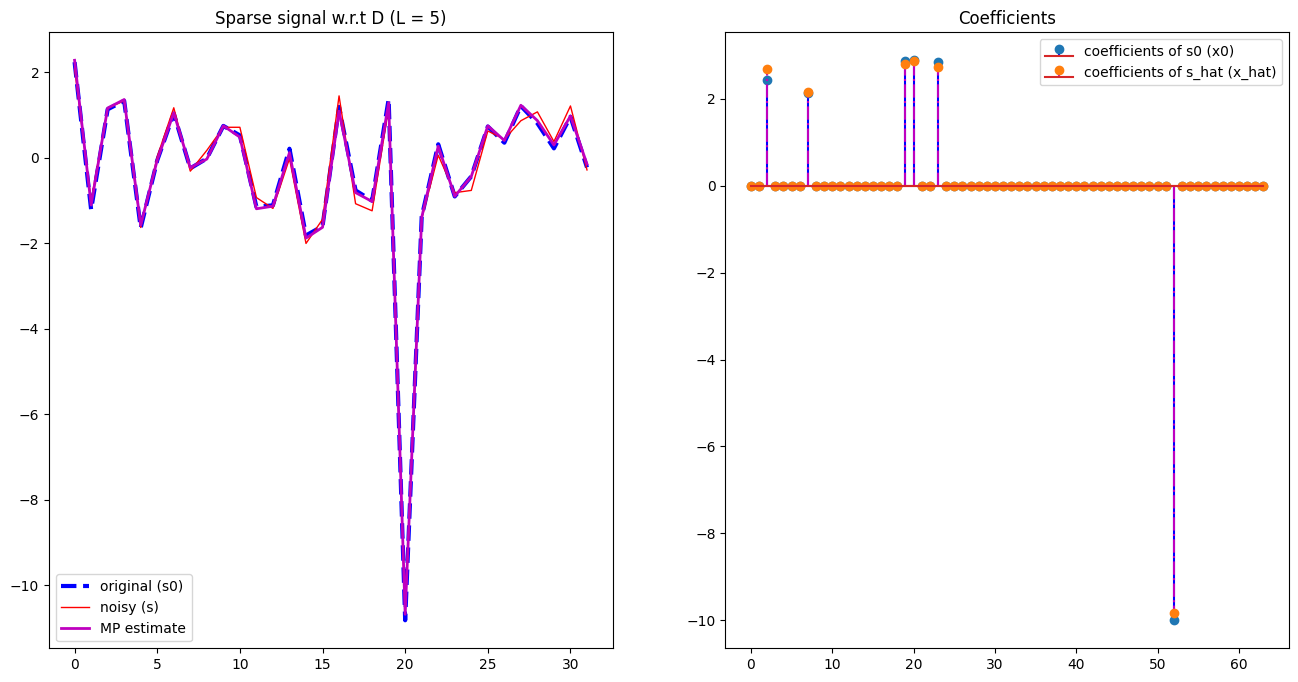

In [171]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b--', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_LSOMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_LSOMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])